In [1]:
import requests
import re
import json

def extract_json_from_html(url, save_output=False):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return "Failed to retrieve the HTML content. Status code: {}".format(response.status_code)

    html = response.text
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    match = re.findall(regex_pattern, html)
    if not match:
        return "No match found"

    # Correcting data format by adding quotes around keys
    data_txt = match[0]
    keys_to_replace = ['matchId', 'matchCentreData', 'matchCentreEventTypeJson', 'formationIdNameMappings']
    for key in keys_to_replace:
        data_txt = data_txt.replace(key, f'"{key}"')
    data_txt = data_txt.replace('};', '}')

    # Try to parse the JSON data
    try:
        data_json = json.loads(data_txt)
    except json.JSONDecodeError:
        return "JSON decoding failed"

    # Print the JSON structure summarization
    print_json_structure(data_json)

    # Optionally, save the JSON data to a text file
    if save_output:
        output_filename = 'output.txt'
        with open(output_filename, 'w', encoding='utf-8') as output_file:
            json.dump(data_json, output_file, indent=4)

    return data_json

def print_json_structure(data, indent=0, max_list_example=3):
    for key, value in data.items():
        if isinstance(value, dict):
            print('  ' * indent + f"{key} (dict with {len(value.keys())} keys)")
            print_json_structure(value, indent + 1)
        elif isinstance(value, list):
            print('  ' * indent + f"{key} (list with {len(value)} items)")
            if value:
                if isinstance(value[0], dict):
                    print('  ' * (indent + 1) + f"Example item from list:")
                    print_json_structure(value[0], indent + 2)
                else: 
                    example_items = value[:max_list_example]
                    print('  ' * (indent + 1) + f"Example items: {example_items}")
        else:
            print('  ' * indent + f"{key} ({type(value).__name__})")



In [2]:
## replace with the match wanted to scrape
url = "https://www.whoscored.com/Matches/1813972/Live/Europe-Champions-League-2023-2024-Bayern-Munich-Real-Madrid"
data = extract_json_from_html(url, save_output=True)


matchId (int)
matchCentreData (dict with 28 keys)
  playerIdNameDictionary (dict with 42 keys)
    248010 (str)
    29809 (str)
    320040 (str)
    422885 (str)
    327721 (str)
    481079 (str)
    283323 (str)
    119501 (str)
    144711 (str)
    35506 (str)
    37099 (str)
    13754 (str)
    115519 (str)
    395252 (str)
    404258 (str)
    349932 (str)
    115375 (str)
    429273 (str)
    117973 (str)
    83532 (str)
    370912 (str)
    73798 (str)
    337782 (str)
    337879 (str)
    347862 (str)
    20874 (str)
    296337 (str)
    353423 (str)
    369109 (str)
    104010 (str)
    31772 (str)
    317541 (str)
    106875 (str)
    113880 (str)
    144511 (str)
    144890 (str)
    74603 (str)
    415181 (str)
    345031 (str)
    344644 (str)
    379868 (str)
    422957 (str)
  periodMinuteLimits (dict with 4 keys)
    1 (int)
    2 (int)
    3 (int)
    4 (int)
  timeStamp (str)
  attendance (int)
  venueName (str)
  referee (dict with 5 keys)
    officialId (int)
    fir

In [3]:
import pandas as pd
import json

def extract_data_from_dict(data):
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {
        data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
        data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']
    }
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]

    # Creating players dataframes
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']

    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']

    # Combine the home and away players into a single DataFrame
    players_df = pd.concat([players_home_df, players_away_df], ignore_index=True)

    return events_dict, players_df, teams_dict


In [4]:
import pandas as pd

def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # Filter only passes with outcomeType equal to "Successful"
    df_passes = df[(df['eventType'] == 'Pass') & (df['outcomeType'] == 'Successful')]

    # Create receiver column based on the next event
    # This will be correct only for successful passes
    df_passes["receiver"] = df_passes["playerId"].shift(-1)

    # Keep only relevant columns
    df_passes = df_passes[["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes


In [5]:
events_dict, players_df, teams_dict = extract_data_from_dict(data)
print(teams_dict)
passes_df = get_passes_df(events_dict)
passes_df.head()

{37: 'Bayern', 52: 'Real Madrid'}


C:\Users\2998542\AppData\Local\Temp\ipykernel_29752\951560948.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_passes["receiver"] = df_passes["playerId"].shift(-1)


,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.680925e+09,50.0,50.0,22.6,52.8,37,395252.0,117973.0,Pass,Successful
5,2.680925e+09,57.0,82.8,60.8,93.0,37,117973.0,349932.0,Pass,Successful
6,2.680925e+09,58.6,95.6,31.3,81.5,37,349932.0,117973.0,Pass,Successful
7,2.680925e+09,31.3,81.5,14.3,54.3,37,117973.0,13754.0,Pass,Successful
8,2.680925e+09,14.3,53.6,29.5,86.9,37,13754.0,115519.0,Pass,Successful


In [6]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    print(team_id)
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')
    print(average_locs_and_count_df)

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = pd.pivot_table(passes_player_ids_df, 
                                    index=['pos_min', 'pos_max'], 
                                    values='id', 
                                    aggfunc='count').reset_index()
    passes_between_df.rename(columns={'id': 'pass_count'}, inplace=True)


    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [7]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)
home_passes_between_df

# Using len() function
num_passes = len(home_passes_between_df)
print("Number of passes:", num_passes)

# Using .shape attribute
num_passes_alt = home_passes_between_df.shape[0]
print("Number of passes (alternative method):", num_passes_alt)


37
                  x          y  count               name  shirtNo position
playerId                                                                  
13754.0   13.996774  51.409677     31       Manuel Neuer        1       GK
37099.0   68.015385  32.211538     26      Thomas Müller       25      AMC
83532.0   53.892308  50.053846     13         Harry Kane        9       FW
115519.0  58.027027  58.805405     37      Leon Goretzka        8      DMC
117973.0  36.270886  74.432911     79          Eric Dier       15       DC
144711.0  62.773684  53.100000     19         Leroy Sané       10      AML
248010.0  50.478947  38.560526     76      Konrad Laimer       27      DMC
283323.0  56.640000  13.928571     70     Joshua Kimmich        6       DR
349932.0  52.437778  88.373333     45  Noussair Mazraoui       40       DL
370912.0  38.036111  28.195833     72        Kim Min-Jae        3       DC
395252.0  56.048387  39.838710     31      Jamal Musiala       42      AMR
Number of passes: 51
N

In [8]:
import itertools

def find_missing_passes(passes_between_df, average_locs_and_count_df):
    # Extract player IDs
    player_ids = average_locs_and_count_df.index.tolist()
    
    # Generate all possible combinations of player pairs
    all_possible_pairs = list(itertools.combinations(player_ids, 2))
    
    # Extract the player pairs that occurred in passes_between_df
    occurred_pairs = set(zip(passes_between_df['pos_min'], passes_between_df['pos_max']))
    
    # Find missing passes
    missing_passes = [pair for pair in all_possible_pairs if pair not in occurred_pairs]
    
    return missing_passes

# Assuming you have the DataFrame home_passes_between_df and average_locs_and_count_df
missing_passes = find_missing_passes(home_passes_between_df, home_average_locs_and_count_df)

print("Missing Passes:")
for pair in missing_passes:
    player1_name = home_average_locs_and_count_df.loc[pair[0], 'name']
    player2_name = home_average_locs_and_count_df.loc[pair[1], 'name']
    print(f"{player1_name} -> {player2_name}")


Missing Passes:
Manuel Neuer -> Thomas Müller
Manuel Neuer -> Harry Kane
Manuel Neuer -> Leroy Sané
Manuel Neuer -> Jamal Musiala
Thomas Müller -> Eric Dier
Noussair Mazraoui -> Kim Min-Jae


In [9]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)
away_passes_between_df.head()

num_passes = len(away_passes_between_df)
print("Number of passes:", num_passes)

# Using .shape attribute
num_passes_alt = away_passes_between_df.shape[0]
print("Number of passes (alternative method):", num_passes_alt)

52
                  x          y  count                 name  shirtNo position
playerId                                                                    
31772.0   44.826250  56.280000     80           Toni Kroos        8       MC
104010.0  32.951163  40.267442     43      Antonio Rüdiger       22       DC
106875.0  36.445714  65.551429     35                Nacho        6       DC
144511.0  46.681034   8.381034     58        Lucas Vázquez       17       DR
296337.0  42.730303  90.469697     33        Ferland Mendy       23       DL
337782.0  57.559259  71.718519     27      Vinícius Júnior        7       FW
344644.0  50.069048  30.423810     42    Federico Valverde       15       MR
345031.0   8.151852  48.014815     27         Andriy Lunin       13       GK
347862.0  59.404000  62.508000     25              Rodrygo       11       ML
353423.0  43.833333  40.398148     54  Aurélien Tchouaméni       18       MC
379868.0  54.940909  50.772727     44      Jude Bellingham        5      

### Visualization

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [11]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#FEFEFC', edgecolors='#FEFEFC', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        print(row)
        player_name = row["name"].split()
        player_shirt_no = row["shirtNo"]
        player_initials = "".join(word[0] for word in player_name).upper()
        pitch.annotate(player_shirt_no, xy=(row.x, row.y), c='#C4C4C4', va='center',
                       ha='center', size=14, ax=ax)

    return pitch

x                 13.996774
y                 51.409677
count                    31
name           Manuel Neuer
shirtNo                   1
position                 GK
marker_size      1177.21519
Name: 13754.0, dtype: object
x                  68.015385
y                  32.211538
count                     26
name           Thomas Müller
shirtNo                   25
position                 AMC
marker_size       987.341772
Name: 37099.0, dtype: object
x               53.892308
y               50.053846
count                  13
name           Harry Kane
shirtNo                 9
position               FW
marker_size    493.670886
Name: 83532.0, dtype: object
x                  58.027027
y                  58.805405
count                     37
name           Leon Goretzka
shirtNo                    8
position                 DMC
marker_size      1405.063291
Name: 115519.0, dtype: object
x              36.270886
y              74.432911
count                 79
name           Eric Dier

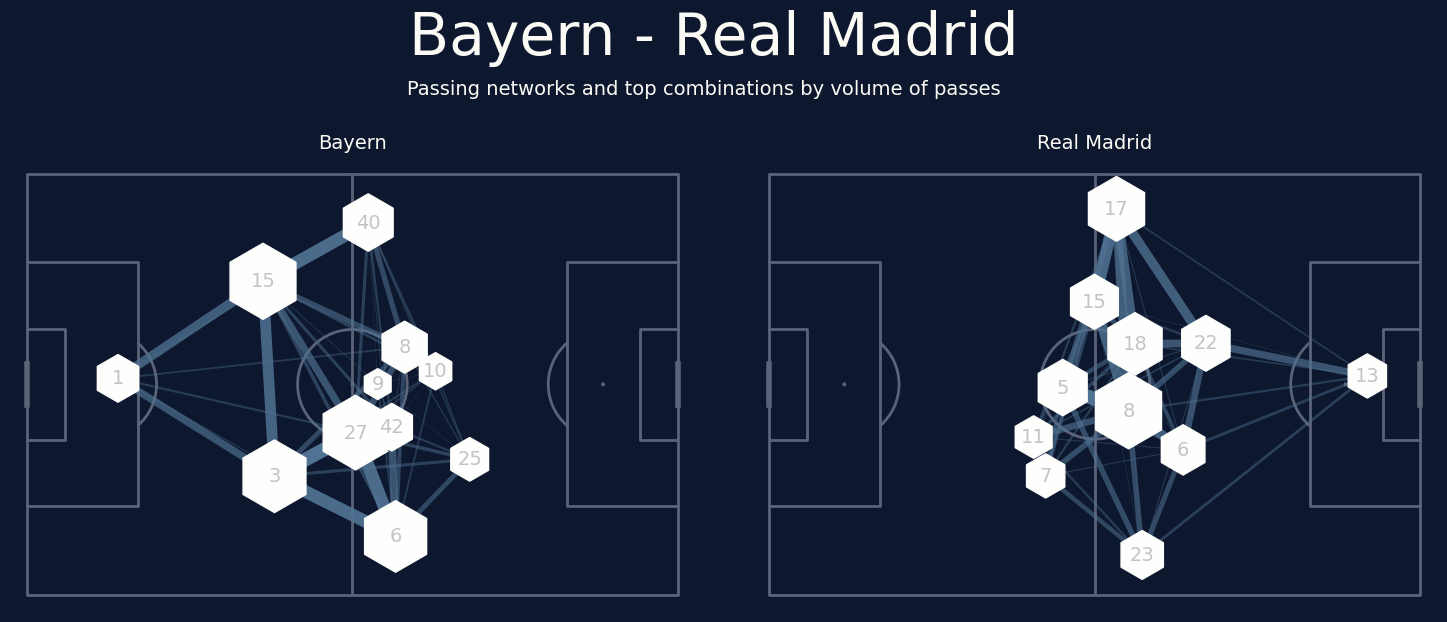

In [12]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14 )

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('output.png', bbox_inches='tight')
plt.show()

## Netwrok analysis

In [13]:
# Filter passes where the outcomeType is "Successful"
successful_passes_df = passes_df[passes_df["outcomeType"] == "Successful"]

# Filter passes where the outcomeType is not "Successful" (i.e., unsuccessful passes)
unsuccessful_passes_df = passes_df[passes_df["outcomeType"] != "Successful"]

# Print the DataFrame containing unsuccessful passes
print("\nUnsuccessful Passes:")
print(unsuccessful_passes_df)



Unsuccessful Passes:
Empty DataFrame
Columns: [id, x, y, endX, endY, teamId, playerId, receiver, eventType, outcomeType]
Index: []


In [14]:
import pandas as pd

def get_directed_passes_between_df(team_id, passes_df, players_df):
    # Filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]
    # Filter passes where the outcomeType is "Successful"
    passes_df = passes_df[passes_df["outcomeType"] == "Successful"]

    # Filter for first eleven players
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

   

    # Calculate mean positions for players
    average_locs_and_count_df = passes_df.groupby('playerId').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # Get passes between each player
    passes_between_df = passes_df.groupby(['playerId', 'receiver']).size().reset_index(name='pass_count')

    # Merge player location data
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='playerId', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='receiver', right_index=True,
                                                suffixes=['', '_end'])

    return passes_between_df, average_locs_and_count_df


away_directed_passes_between_df, away_average_locs_and_count_df = get_directed_passes_between_df(away_team_id, successful_passes_df, players_df)
away_directed_passes_between_df.head()
away_num_directed_passes = len(away_directed_passes_between_df)
print("Away Number of directed passes:", away_num_directed_passes)

home_directed_passes_between_df, home_average_locs_and_count_df = get_directed_passes_between_df(home_team_id, successful_passes_df, players_df)
home_directed_passes_between_df.head()
home_num_directed_passes = len(home_directed_passes_between_df)
print("home Number of directed passes:", home_num_directed_passes)



Away Number of directed passes: 96
home Number of directed passes: 91


In [15]:
away_directed_passes_between_df

,playerId,receiver,pass_count,x,y,count,name,shirtNo,position,x_end,y_end,count_end,name_end,shirtNo_end,position_end
1,31772.0,31772.0,2,44.826250,56.280000,80,Toni Kroos,8,MC,44.826250,56.280000,80,Toni Kroos,8,MC
17,104010.0,31772.0,6,32.951163,40.267442,43,Antonio Rüdiger,22,DC,44.826250,56.280000,80,Toni Kroos,8,MC
29,106875.0,31772.0,10,36.445714,65.551429,35,Nacho,6,DC,44.826250,56.280000,80,Toni Kroos,8,MC
38,144511.0,31772.0,6,46.681034,8.381034,58,Lucas Vázquez,17,DR,44.826250,56.280000,80,Toni Kroos,8,MC
56,296337.0,31772.0,7,42.730303,90.469697,33,Ferland Mendy,23,DL,44.826250,56.280000,80,Toni Kroos,8,MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,296337.0,379868.0,2,42.730303,90.469697,33,Ferland Mendy,23,DL,54.940909,50.772727,44,Jude Bellingham,5,FW
75,337782.0,379868.0,4,57.559259,71.718519,27,Vinícius Júnior,7,FW,54.940909,50.772727,44,Jude Bellingham,5,FW
91,344644.0,379868.0,4,50.069048,30.423810,42,Federico Valverde,15,MR,54.940909,50.772727,44,Jude Bellingham,5,FW
112,347862.0,379868.0,1,59.404000,62.508000,25,Rodrygo,11,ML,54.940909,50.772727,44,Jude Bellingham,5,FW


In [21]:
import pandas as pd
import networkx as nx
import pandas as pd
import networkx as nx

def analyze_pass_network(passes_df, min_passes):
    """
    Analyze the pass network from a DataFrame of passes between players.
    
    Parameters:
    - passes_df: DataFrame containing pass data.
    - min_passes: Minimum number of passes required to consider an edge valid.

    Returns:
    - A tuple of dictionaries containing centrality measures and network properties.
    """
    # Initialize a directed graph

    G = nx.DiGraph()

    # Add edges from DataFrame with filtering based on min_passes
    for idx, row in passes_df.iterrows():
        if row['pass_count'] >= min_passes:
            G.add_edge(row['name'], row['name_end'], weight=row['pass_count'])

        # G.add_edge(row['name'], row['name_end'], weight=row['pass_count'])

    # Debug: print the number of nodes and edges
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")

    # Calculate centrality measures
    centrality_measures = {
        'betweenness': nx.betweenness_centrality(G, weight='weight'),
        'in_degree': nx.in_degree_centrality(G),
        'out_degree': nx.out_degree_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'degree': nx.degree_centrality(G),
        'eigenvector': nx.eigenvector_centrality_numpy(G) if nx.is_connected(G.to_undirected()) else {}
    }

    # Calculate network properties
    network_properties = {
        'density': nx.density(G),
        'clustering_coefficient': nx.average_clustering(G, weight='weight'),
        'average_degree': sum(dict(G.degree(weight='weight')).values()) / float(G.number_of_nodes()),
        'transitivity': nx.transitivity(G)
    }

    # Handle average shortest path length for directed and undirected graphs
    if nx.is_strongly_connected(G):
        network_properties['average_shortest_path_length'] = nx.average_shortest_path_length(G, weight='weight')
    elif nx.is_connected(G.to_undirected()):
        network_properties['average_shortest_path_length'] = nx.average_shortest_path_length(G.to_undirected(), weight='weight')
    else:
        network_properties['average_shortest_path_length'] = None

    return centrality_measures, network_properties


# Example usage:
# home_passes_between_df = pd.read_csv('path_to_your_dataframe.csv')
centrality, properties = analyze_pass_network(away_directed_passes_between_df, min_passes=3)

# Optionally display the results
# print("Centrality Measures:", centrality)
print("Network Properties:", properties)


Number of nodes: 11
Number of edges: 57
Network Properties: {'density': 0.5181818181818182, 'clustering_coefficient': 0.2720279179673997, 'average_degree': 63.09090909090909, 'transitivity': 0.6203007518796992, 'average_shortest_path_length': 7.627272727272727}


In [17]:
import networkx as nx
import pandas as pd

# Create an undirected graph
G = nx.from_pandas_edgelist(away_passes_between_df, 'name', 'name_end', create_using=nx.Graph())

# Calculate centrality measures
centrality_measures = {
    'betweenness': nx.betweenness_centrality(G),
    'degree': dict(G.degree()),
    'closeness': nx.closeness_centrality(G),
    # 'eigenvector': nx.eigenvector_centrality(G)
}

# Calculate network properties
network_properties = {
    'density': nx.density(G),
    'clustering_coefficient': nx.average_clustering(G),
    'average_degree': sum(dict(G.degree()).values())/G.order(),
    'transitivity': nx.transitivity(G)
}

# average_shortest_path_length = nx.average_shortest_path_length(G)

# print(centrality_measures)
print(network_properties)
# print(average_shortest_path_length)


{'density': 1.018181818181818, 'clustering_coefficient': 0.9325396825396823, 'average_degree': 10.181818181818182, 'transitivity': 0.9295774647887324}
